In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
import numpy as np
import time

# Model

In [2]:
class CIFAR10Classifier:
    def __init__(self, N=1000, K=5, num_epochs=30):
        #We used ResNet18 as our model.
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = torchvision.models.resnet18(pretrained=False).to(self.device)
        self.model.fc = torch.nn.Linear(512, 10).to(self.device)
        self.criterion = torch.nn.CrossEntropyLoss()
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=0.001)  
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
        self.batch_size = 64
        self.num_epochs = num_epochs
        self.N = N
        self.K = K
        self.train_dataset = None
        self.test_dataset = None
        self.train_dataloader = None
        self.test_dataloader = None

        #We are recording these because we need for graphs
        self.accuracy = []
        self.losses = []
        self.sizes = []
        self.times = []
        self.total_times = []

    def load_datasets(self):
        self.train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=self.transform)
        self.test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=self.transform)
        return self.train_dataset, self.test_dataset

    def train(self):
        self.model.train()
        total_time = 0
        for epoch in range(self.num_epochs):
            start_time = time.time()

            #If current size of training batch is smaller than total training data
            #Take random part of training data from whole of it
            if self.N < len(self.train_dataset):
                subset_indices = np.random.choice(len(self.train_dataset), self.N, replace=False)
                subset_dataset = Subset(self.train_dataset, subset_indices)
                self.train_dataloader = DataLoader(subset_dataset, batch_size=self.batch_size, shuffle=True)

            #If current size of training batch is equal to total training data
            #Take thw whole training data
            else:
                self.train_dataloader = DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True)
                self.N = len(self.train_dataset)

            correct = 0
            total = 0
            for batch in self.train_dataloader:
                inputs, labels = batch
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                self.optimizer.zero_grad()
                outputs = self.model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                loss = self.criterion(outputs, labels)
                loss.backward()
                self.optimizer.step()


            #Record epoch time
            #And save epoch time, whole time
            end_time = time.time()
            execution_time = end_time - start_time
            total_time += execution_time
            self.times.append(execution_time)
            self.total_times.append(total_time)

            #Save size, loss
            #Calculate accuracy and save
            size = self.N
            self.sizes.append(size)
            self.losses.append(loss.item())
            accuracy = 100 * correct / total
            self.accuracy.append(accuracy)

            print(f'Epoch [{epoch+1}/{self.num_epochs}], Loss: {loss.item():.4f}, Accuracy: {accuracy}, Current size: {size}, Time: {execution_time}, Total time: {total_time}')

            #Doubling the training size
            #Depending on K value
            #Which we give the model
            if epoch % self.K == 0:
                self.N *= 2

    def predict(self):
        self.model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            self.test_dataloader = DataLoader(self.test_dataset, batch_size=self.batch_size, shuffle=False)
            for data in self.test_dataloader:
                images, labels = data
                images, labels = images.to(self.device), labels.to(self.device)
                outputs = self.model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()


        print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))

        return 100 * correct / total




# Testing with different parameters

In [3]:
params = [(4,100), (4, 250), (4, 500), (4,1000), (4, 2500), (4, 5000), (5, 5000), (100, 50000)]

dict_acc = {}
dict_loss = {}
dict_size = {}
dict_time = {}
dict_total_time = {}
dict_test_acc = {}

In [4]:
models = {}
for param in params:
    K, N = param
    epoch = 30
    model = CIFAR10Classifier(N, K, epoch)
    train_dataset, test_dataset = model.load_datasets()

    model.train()
    dict_acc[param] = model.accuracy
    dict_loss[param] = model.losses
    dict_size[param] = model.sizes
    dict_test_acc[param] = model.predict()
    dict_time[param] = model.times
    dict_total_time[param] = model.total_times
    models[param] = model



/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


100%|██████████| 170498071/170498071 [00:02<00:00, 58310738.64it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Epoch [1/30], Loss: 2.4657, Accuracy: 14.0, Current size: 100, Time: 1.3149988651275635, Total time: 1.3149988651275635
Epoch [2/30], Loss: 2.0889, Accuracy: 16.5, Current size: 200, Time: 0.1705949306488037, Total time: 1.4855937957763672
Epoch [3/30], Loss: 2.1036, Accuracy: 23.0, Current size: 200, Time: 0.11604738235473633, Total time: 1.6016411781311035
Epoch [4/30], Loss: 2.2977, Accuracy: 21.5, Current size: 200, Time: 0.11205482482910156, Total time: 1.713696002960205
Epoch [5/30], Loss: 2.6132, Accuracy: 22.5, Current size: 200, Time: 0.11199188232421875, Total time: 1.8256878852844238
Epoch [6/30], Loss: 2.1616, Accuracy: 27.75, Current size: 400, Time: 0.22249937057495117, Total time: 2.048187255859375
Epoch [7/30], Loss: 2.2228, Accuracy: 30.5, Current size: 400, Time: 0.20039749145507812, Total time: 2.248584747314453
Epoch [8/30], Loss: 1.5851, Accuracy: 29.75, Current size: 400, Time

# Plotting

In [6]:
import matplotlib.pyplot as plt

In [7]:
marker_styles = {(4,100):'o',
                 (4,250):'^',
                 (4,500):'*',
                 (4,1000):'x',
                 (4,2500):'D',
                 (4,5000):'v',
                 (5,5000):'s',
                 (100,50000):'p'}

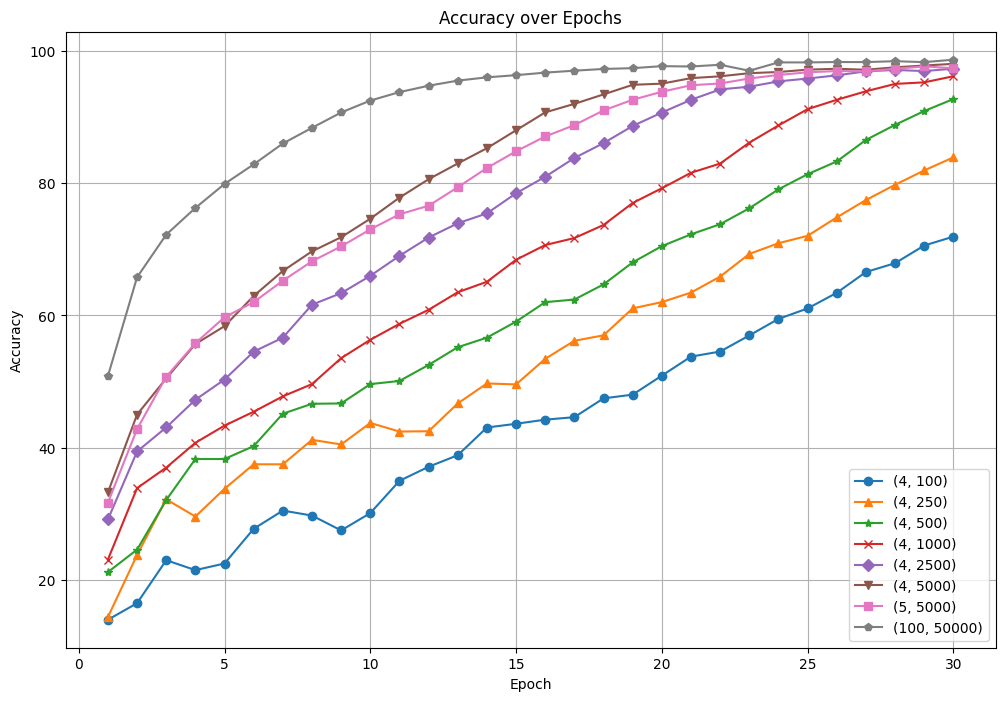

In [8]:
plt.figure(figsize=(12, 8))
for param, acc_list in dict_acc.items():
    plt.plot(range(1, 31), acc_list, label=param, marker=marker_styles[param])
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

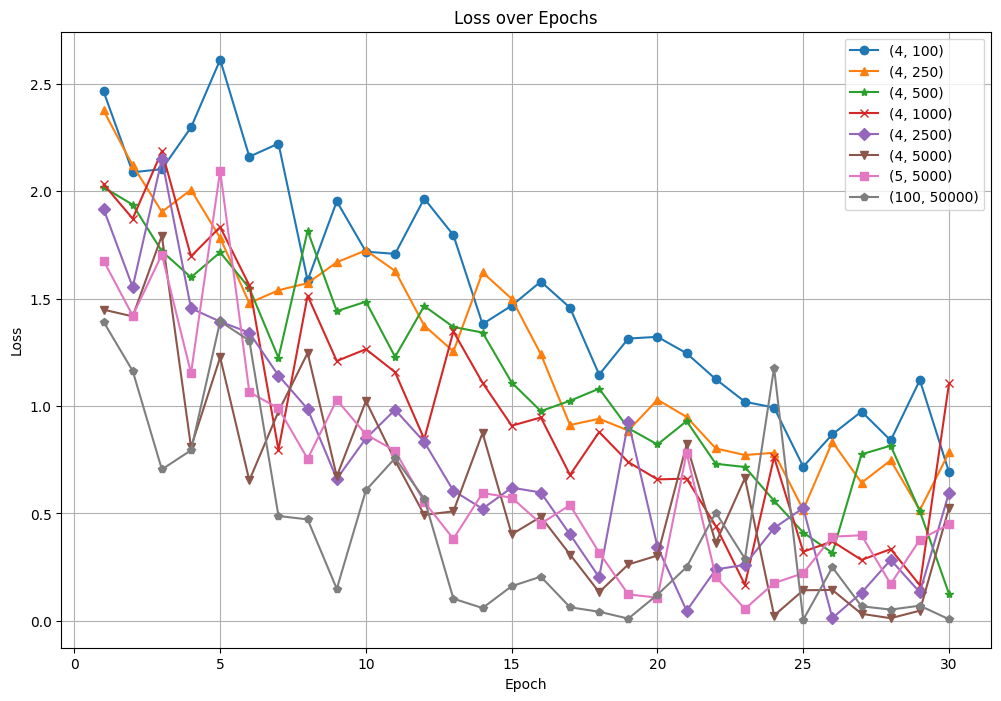

In [9]:
plt.figure(figsize=(12, 8))
for param, loss_list in dict_loss.items():
    plt.plot(range(1, 31), loss_list, label=param, marker=marker_styles[param])
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

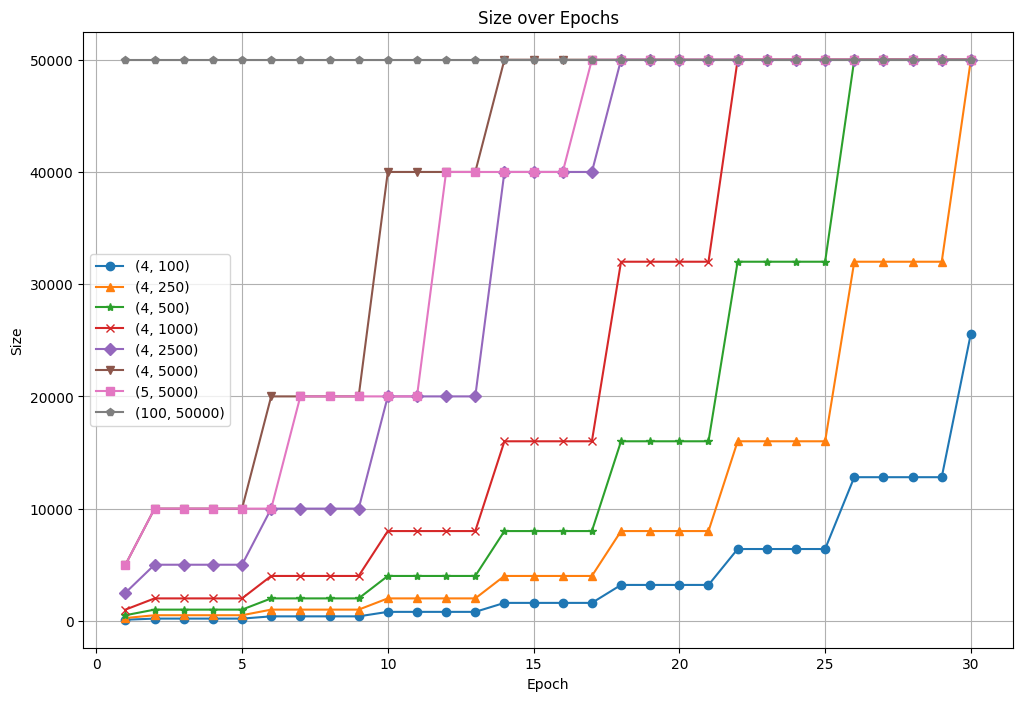

In [10]:
plt.figure(figsize=(12, 8))
for param, size_list in dict_size.items():
    plt.plot(range(1, 31), size_list, label=param, marker=marker_styles[param])
plt.title('Size over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Size')
plt.legend()
plt.grid(True)
plt.show()

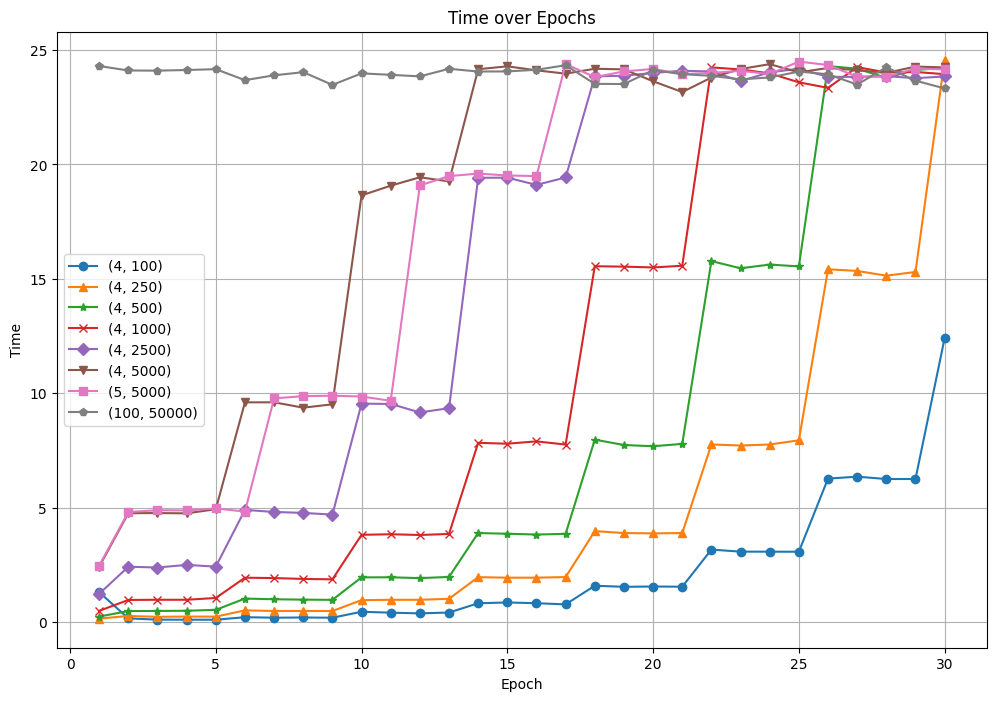

In [11]:
plt.figure(figsize=(12, 8))
for param, size_list in dict_time.items():
    plt.plot(range(1, 31), size_list, label=param, marker=marker_styles[param])
plt.title('Time over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Time')
plt.legend()
plt.grid(True)
plt.show()

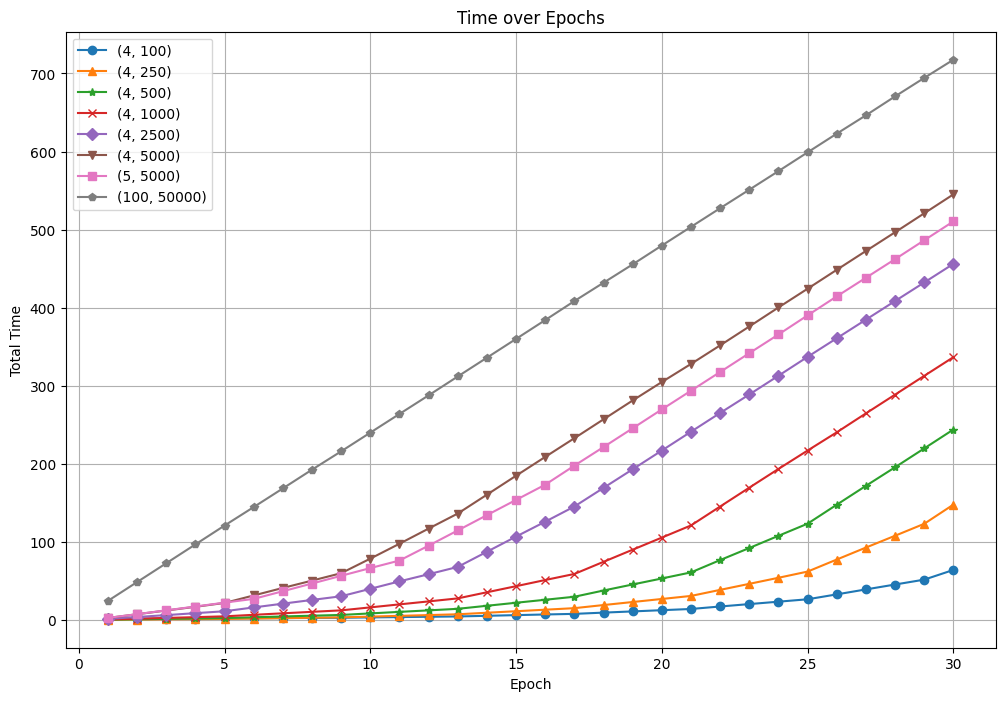

In [14]:
plt.figure(figsize=(12, 8))
for param, size_list in dict_total_time.items():
    plt.plot(range(1, 31), size_list, label=param, marker=marker_styles[param])
plt.title('Time over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Total Time')
plt.legend()
plt.grid(True)
plt.show()